# Pseudo-Synchronization

This adds self consistent spin, tidal and dynamical equations of motion in the equilibrium tide model as outlined by Eggleton et. al (1998). In this simple example we confirm the prediction of pseudo-synchronization for a fiducial hot Jupiter. This example can be seen in Millholland & Laughlin (2019) and is Figure 2 in Lu et al. (2023).

In [1]:
import rebound
import reboundx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We'll set up the system in the traditional REBOUND framework first. We set up a fiducial hot Jupiter in a near-circular orbit around a solar-type star

In [2]:
sim = rebound.Simulation()
# Star
ms = 1
rs = 0.00465
sim.add(m = ms, r = rs)

# Planet
mp = 9.55e-4
rp = 4.676e-4
ap = 0.04072
ep = 0.01
sim.add(m = mp, r = rp, a = ap, e = ep)
ps = sim.particles

Now, we add the extra parameters necessary to calculate the spin and tidal effects. Let's first set the Love number, moment of inertia, and spin vector. In this simulation both bodies have structure.

In [3]:
rebx = reboundx.Extras(sim)
sf = rebx.load_force("tides_spin")
rebx.add_force(sf)

# Star parameters
ps[0].params['k2'] = 0.07
ps[0].params['moi'] = 0.07 * ms * rs**2
# The magnitude of the spin axis is the spin frequency. We initialize the star's obliquity as 0
spin_period_star = (27 / 365) * 2 * np.pi # 27 days in default REBOUND units
spin_mag_star = 2 * np.pi / spin_period_star
ps[0].params['spin_sx'] = 0 
ps[0].params['spin_sy'] = 0
ps[0].params['spin_sz'] = spin_mag_star

# Planet parameters
ps[1].params['k2'] = 0.3
ps[1].params['moi'] = 0.25 * mp * rp**2
# Initialize the planet's obliquity to 30 degrees
spin_period_planet = (0.5 / 365) * 2 * np.pi # 0.5 days in default REBOUND units
spin_mag_planet = 2 * np.pi / spin_period_planet
obliquity_planet = np.radians(30)
phi_planet = 0
ps[1].params['spin_sx'] = spin_mag_planet * np.sin(obliquity_planet) * np.sin(phi_planet)
ps[1].params['spin_sy'] = spin_mag_planet * np.sin(obliquity_planet) * np.cos(phi_planet)
ps[1].params['spin_sz'] = spin_mag_planet * np.cos(obliquity_planet)

We saved the tidal dissipation parameter $\sigma$ for last because there are a few different ways to set it. $\sigma$ may be set traditionally, but this parameter is not widely adopted. We can relate $\sigma$ to two more traditionally used quantities: the time lag $\tau$ and the tidal quality factor $Q$. 

Specifically, the relations are:

$\tau = \frac{3 \sigma r^5}{4G} k_2$, $Q^{-1} \sim 2 n \tau$

The first relation is always valid, while the second is only strictly valid for synchronized circular orbits (see Section 2 of Lu et. al (2023) for more discussion regarding these approximations).

In [4]:
# All three expressions below are equivalent in our framework
# Star Q
stellar_q = 1e6
stellar_tau = 1 / (2 * stellar_q * ps[1].n)
stellar_sigma = 4 * sim.G * stellar_tau / (3 * ps[0].r**5 * ps[0].params['k2'])

# Planet Q
planet_q = 1e4
planet_tau = 1 / (2 * planet_q * ps[1].n)
planet_sigma = 4 * sim.G * planet_tau / (3 * ps[1].r**5 * ps[1].params['k2'])

We have provided two helper functions that will set the desired value of $\sigma$ given an input $Q$ or $\tau$. While setting $\sigma$ traditionally has no restrictions, to use the helper functions all other relevant quantities must be set already. Therefore, call these LAST.

In [5]:
# Setting sigma for the star: all three of these functions do the same thing
'''
set_q takes in as arguments, in order: 
the G value, the particle you wish to set sigma for, the perturbing particle, and the tidal Q
'''
ps[0].params['sigma'] = rebx.set_q(sim.G, ps[0], ps[1], stellar_q)
# ps[0].params['sigma'] = rebx.set_time_lag(sim.G, ps[0], stellar_tau)
# ps[0].params['sigma'] = stellar_sigma

# For the planet
'''
set_tau takes in as arguments, in order:
the G value, the particle you wish to set sigma for, the time lag
'''
ps[1].params['sigma'] = rebx.set_time_lag(sim.G, ps[1], planet_tau)
# ps[1].params['sigma'] = planet_sigma
# ps[1].params['sigma'] = rebx.set_q(sim.G, ps[1], ps[0], planet_q)

Some bookkeeping before we begin integrating the system: choosing an integrator, moving to the CoM, and aligning the system to the invariant plane (which aligns the spins as well as the orbits of the bodies)

In [6]:
sim.integrator = "whfast"
sim.dt = sim.particles[1].P/10.1234567 # timestep is a fraction of the orbital period
sim.move_to_com()
rebx.align_simulation()

The next step is mandatory: to track the evolution of the spin axis, you MUST call the function `initialize_spin_ode`. Otherwise the spin axis will remain stationary and you won't see anything interesting!

In [7]:
rebx.initialize_spin_ode(sf)

Now, we integrate. We'll track the hot Jupiters's spin axis, semimajor axis, and eccentricity.

In [8]:
tmax = 2 * np.pi * 1e4
Nout = 1000
times = np.linspace(0, tmax, Nout)

planet_spin_axis = np.zeros((Nout, 3))
planet_a = np.zeros(Nout)
planet_e = np.zeros(Nout)

for i, t in enumerate(times):
    planet_spin_axis[i] = [ps[1].params['spin_sx'], ps[1].params['spin_sy'], ps[1].params['spin_sz']]
    planet_a[i] = ps[1].a
    planet_e[i] = ps[1].e
    
    sim.integrate(t)

Let's compare this to analytic results. We'll numerically integrate the same initial conditions with the orbit-averaged expressions from Leconte et. al (2010), which is an equivalent framework to ours.

In [9]:
from scipy.integrate import odeint

def leconte_analytic(params, t, mstar, rstar, k2_star, dt_star, C_s, mp, rp, k2_p, dt_p, C_p):
    '''
    Leconte 2010 Eq (2, 6, 10)
    Assumes REBOUND units (G=1)
    '''
    
    a, e, omega_p, omega_s, ep_p, ep_s = params
    n = np.sqrt((mstar + mp) / a**3)
    
    n_e = (1 + (15 / 2) * e**2 + (45 / 8) * e**4 + (5 / 16) * e**6) / (1 - e**2)**6
    n_a_e = (1 + (31 / 2) * e**2 + (255 / 8) * e**4 + (185 / 16) * e**6 + (25 / 64) * e**8) / (1 -  e**2)**(15 / 2)
    n_e_e = (1 + (15 / 4) * e**2 + (15 / 8) * e**4 + (5 / 64) * e**6) / (1 - e**2)**(13 / 2)
    omega_e_e = (1 + (3 / 2) * e**2 + (1 / 8) * e**4) / (1 - e**2)**5
    omega_e = (1 + 3 * e**2 + (3 / 8) * e**4) / (1 - e**2)**(9 / 2)
    
    Kp = 3 * k2_p * dt_p * (mp**2 / rp) * (mstar / mp)**2 * (rp / a)**6 * n**2
    Kstar = 3 * k2_star * dt_star * (mstar**2 / rstar) * (mp / mstar)**2 * (rstar / a)**6 * n**2
    
    eta_p = (mp + mstar) / (mp * mstar) * (C_p * omega_p) / (a**2 * n * np.sqrt(1 - e**2))
    eta_s = (mp + mstar) / (mp * mstar) * (C_s * omega_s) / (a**2 * n * np.sqrt(1 - e**2))
    
    da_dt = (4 * a**2 / (mstar * mp)) * (Kp * (n_e * np.cos(ep_p) * omega_p / n - n_a_e)
                                       + Kstar * (n_e * np.cos(ep_s) * omega_s / n - n_a_e))
    
    de_dt = (11 * a * e / (mstar * mp)) * (Kp * (omega_e_e * np.cos(ep_p) * omega_p / n - (18 / 11) * n_e_e)
                                         + Kstar * (omega_e_e * np.cos(ep_s) * omega_s / n - (18 / 11) * n_e_e))
    
    domega_p_dt = -(Kp / (n * C_p)) * ((1 + np.cos(ep_p)**2) * omega_e * omega_p / n - 2 * np.cos(ep_p) * n_e)
    domega_s_dt = -(Kstar / (n * C_s)) * ((1 + np.cos(ep_s)**2) * omega_e * omega_s / n - 2 * np.cos(ep_s) * n_e)
    
    dep_p_dt = np.sin(ep_p) * ((Kp / (n * omega_p * C_p)) * 
                               ((np.cos(ep_p) - eta_p) * omega_e * omega_p / n - 2 * n_e))
    dep_s_dt = np.sin(ep_s) * ((Kstar / (n * omega_s * C_s)) * 
                               ((np.cos(ep_s) - eta_s) * omega_e * omega_s / n - 2 * n_e))
    
    return [da_dt, de_dt, domega_p_dt, domega_s_dt, dep_p_dt, dep_s_dt]

initial_condition = [ap, ep, 365 / 0.5, 365 / 27, np.radians(30.), np.radians(0)]
analytic_solution = odeint(leconte_analytic, initial_condition, times,
                              args=(ms, rs, 0.07, 4.11e-9, 0.07 * ms * rs**2,
                                    mp, rp, 0.3, 4.11e-7, 0.25 * mp * rp**2))

Interpreting these results:

In [10]:
# Numeric results
planet_sz = planet_spin_axis[:,2]
planet_spin_mag = np.linalg.norm(planet_spin_axis, axis=1)
planet_obliquity = np.degrees(np.arccos(planet_sz / planet_spin_mag))

planet_n = np.sqrt((ms + mp) / (planet_a**3))

# Analytic results
planet_lec_a = analytic_solution[:,0]
planet_lec_e = analytic_solution[:,1]
planet_lec_n = np.sqrt((ms + mp) / (planet_lec_a**3))
planet_lec_spin = analytic_solution[:,2]
planet_lec_obliquity = np.degrees(analytic_solution[:,4])

Below we have overplotted both the numeric results from our REBOUND simulation, and the analytic results from the Leconte et. al (2010) equations. This reproduces Figure 2 in Lu et. al (2023).

Text(0.5, 0, 'Time (kyr)')

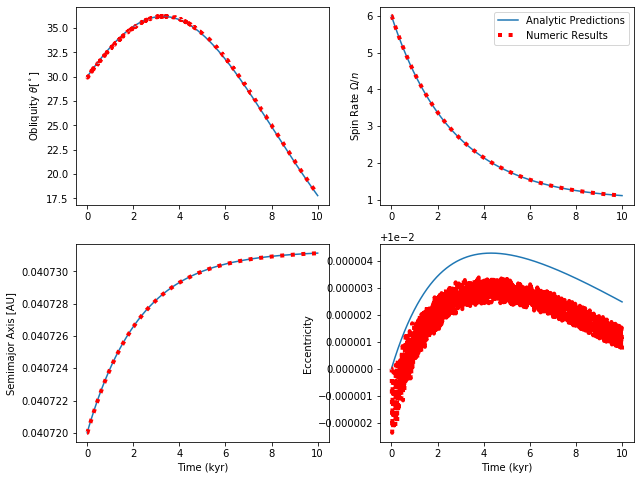

In [11]:
fig, ax = plt.subplots(2,2,figsize=(10,8))#, sharex=True)
ax = ax.ravel()

times_rescaled = times / (1000 * 2 * np.pi) # this converts from REBOUND time units to kyr

ax[0].plot(times_rescaled, planet_lec_obliquity)
ax[0].plot(times_rescaled, planet_obliquity, ls = ':', color = 'red', linewidth=4)
ax[0].set_ylabel(r'Obliquity $\theta [^\circ]$')

ax[1].plot(times_rescaled, planet_lec_spin / planet_lec_n, label = 'Analytic Predictions')
ax[1].plot(times_rescaled, planet_spin_mag / planet_n, ls = ':', color = 'red', lw=4, label='Numeric Results')
ax[1].set_ylabel(r'Spin Rate $\Omega / n$')
ax[1].legend()

ax[2].plot(times_rescaled, planet_lec_a)
ax[2].plot(times_rescaled, planet_a, ls = ':', color = 'red', lw=4)
ax[2].set_ylabel('Semimajor Axis [AU]')
ax[2].set_xlabel('Time (kyr)')

ax[3].plot(times_rescaled, planet_lec_e)
ax[3].plot(times_rescaled, planet_e, ls = ':', color = 'red', lw=4)
ax[3].set_ylabel('Eccentricity')
ax[3].set_xlabel('Time (kyr)')

Clearly, the numeric and analytic results are in excellent agreement! The only noticable difference is in the eccentricity evolution, in which numeric and analytic results vary by less than 0.03% over the course of the evolution!